## Collection of experiments with turicreate library

In [11]:
import turicreate as tc
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def get_sample(mw, frac):
    apks = mw['apk'].unique()
    sample_apks = apks.sample(fraction=frac, seed=42)
    return mw.filter_by(sample_apks, column_name='apk')

In [3]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')
subsamp = get_sample(mw=mw, frac=0.1)

### Right position for $k$

it is not sufficient to set k for `get_similar_items`. The recomended performs a cut-off anyways. The $k$ has to be set in the `create` method (`only_top_k`). 

There is also a `threshold` in `create` initialization, but apparently this has less influece.

In [4]:
k = len(subsamp['apk'].unique())
sim_recom = tc.item_similarity_recommender.create(subsamp, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False, only_top_k=k)
no_k_recom = tc.item_similarity_recommender.create(subsamp, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False) 

In [5]:
def aio_distance(apk1, apk2, k, recommender):
    similar_items = recommender.get_similar_items([apk1], k=k)['similar', 'score']
    similar_items.materialize()
    
    try:
        return 1-similar_items[similar_items['similar']==apk2]['score'][0]
    except:
        return 1

In [6]:
d_nok = lambda x,y: aio_distance(x,y, 0, no_k_recom)
d_1k = lambda x,y: aio_distance(x,y, k, no_k_recom)
d_fk = lambda x,y: aio_distance(x,y, k, sim_recom)

In [7]:
apks = subsamp['apk'].unique()

In [24]:
pairs = [(apks[np.random.randint(k)], apks[np.random.randint(k)]) for _ in range(100)]

In [25]:
distances = pd.DataFrame({'nok': [d_nok(*a) for a in pairs], 'onek': [d_1k(*a) for a in pairs], 'fullk': [d_fk(*a) for a in pairs]})

In [30]:
#using onek is apparently equal to using no k at all?
distances[distances.nok!=distances.onek].shape

(0, 3)

In [31]:
#differences between using k in recomender and no k in recomender
distances[distances.nok!=distances.fullk].shape

(89, 3)

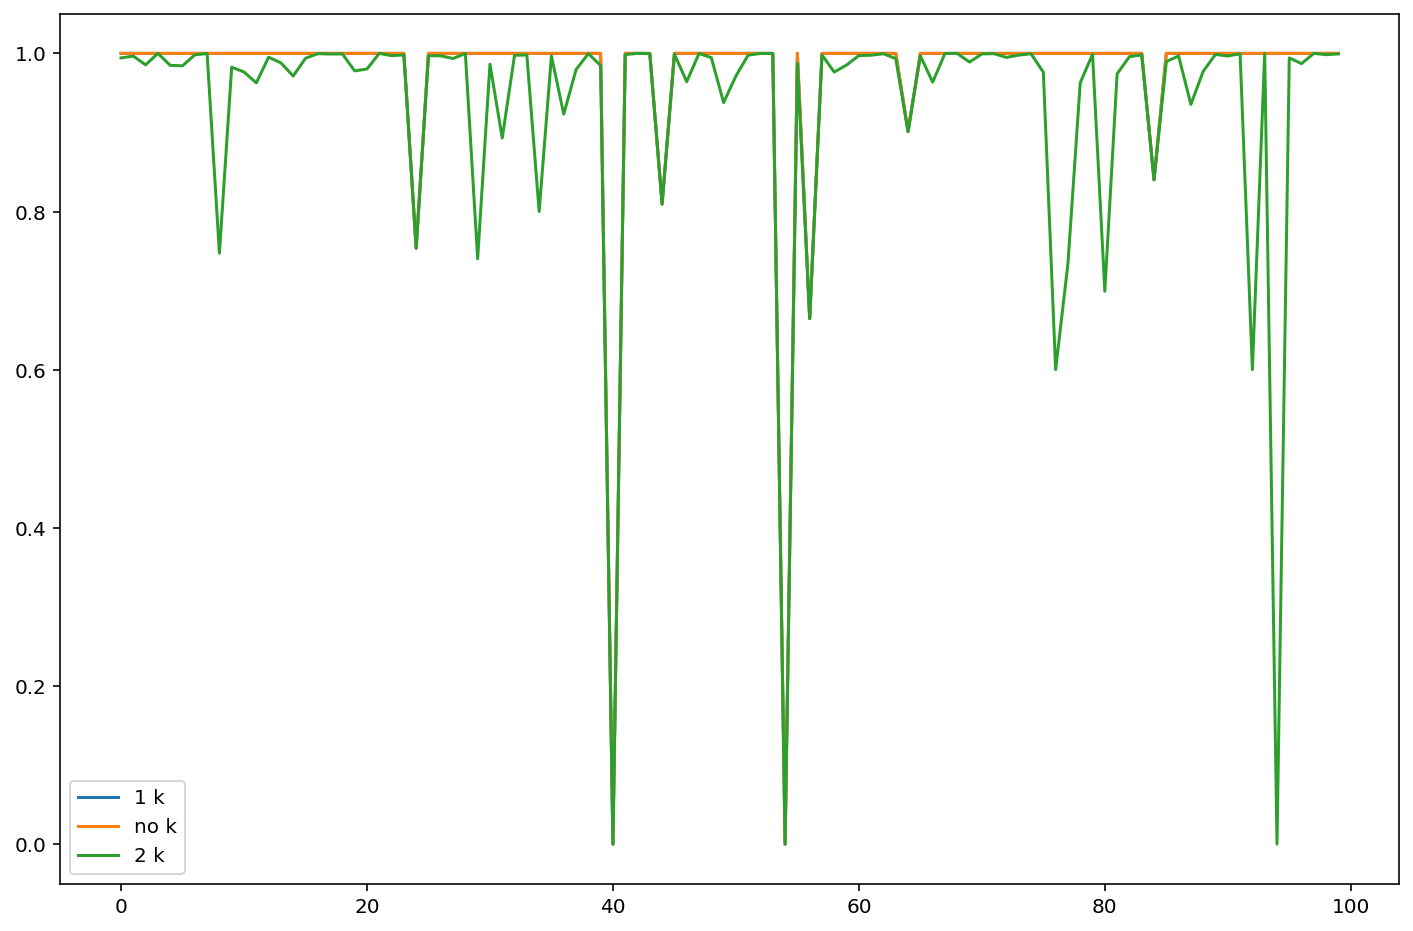

In [27]:
plt.figure(figsize=(12,8))

plt.plot(distances.onek, label='1 k')
plt.plot(distances.nok, label='no k')
plt.plot(distances.fullk, label='2 k')

plt.legend();

### Precision issues
There are visible differences in precision (turi is less precise)

In [28]:
def get_funcs(tab, apk):
    return tab[tab['apk']==apk]['function']

def alt_jaccard(apk1, apk2, tab):
    ap1func = set(get_funcs(tab, apk1))
    ap2func = set(get_funcs(tab, apk2))
    
    return float(len(ap1func & ap2func)) / float(len(ap1func| ap2func))

In [33]:
apk1 = apks[0]
apk2 = apks[1]
print(apk1)

2D151F82FA37F7E52342909747348C7613905B6CDB82CB8005A38299F0D908EB


In [35]:
d_fk(apk1, apk2), 1-alt_jaccard(apk1, apk2, subsamp)#aio_distance(apk1, apk2, rec)

(0.9995647668838501, 0.9995647442872688)

In [36]:
ap1func = set(get_funcs(subsamp, apk1))
ap2func = set(get_funcs(subsamp, apk2))

len(ap1func & ap2func), len(ap1func | ap2func)

(2, 4595)

In [37]:
cup, cut = Out[36]
1- cup/ cut

0.9995647442872688

## Is turi faster than pandas or numpy? no

In [50]:
def jaccard(apid1, apid2, funcs):
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

def panda_jaccard(apid1, apid2, funcs):
    p1 = funcs.loc[apid1]
    p2 = funcs.loc[apid2]
    return 1 - len(p1 & p2)/len(p1|p2)

panda_distance = lambda x,y: panda_jaccard(x,y, funcs_smp)

In [43]:
df = subsamp.to_dataframe()
df.drop(columns=['fcount'], axis=1, inplace=True)
funcs_smp = df.groupby(by='apk')['function'].apply(set)
ffn = funcs_smp.to_numpyumpy()

In [40]:
pairs = [(np.random.randint(len(funcs_smp.index)), np.random.randint(len(funcs_smp.index))) for _ in range(1000)]
apk_pairs = [(funcs_smp.index[a], funcs_smp.index[b]) for a,b in pairs]

In [44]:
%%timeit
## numpy-based 
dis = [jaccard(*a, ffn) for a in pairs]

651 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
## pandas-based
disp = [panda_distance(*a) for a in apk_pairs]

686 ms ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
## turi-no k
disc = [d_nok(*a) for a in apk_pairs]

2.16 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit
## turi-based
disa = [d_fk(*b) for b in apk_pairs]

3.51 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Size matters?

In [ ]:
df = mw.to_dataframe()
df.drop(columns=['fcount'], axis=1, inplace=True)
funcs_smp = df.groupby(by='apk')['function'].apply(set)


In [55]:
ffn = funcs_smp.to_numpy()

In [56]:
k = len(mw['apk'].unique())
sim_recom = tc.item_similarity_recommender.create(mw, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False, only_top_k=k)

In [57]:
d_fk = lambda x,y: aio_distance(x,y, k, sim_recom)

In [58]:
panda_distance = lambda x,y: panda_jaccard(x,y, funcs_smp)

In [59]:
%%timeit
## pandas-based
disp = [panda_distance(*a) for a in apk_pairs]

1 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit
## turi-based
disa = [d_fk(*b) for b in apk_pairs]

12.6 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
